# Goal of the project

There are primarily 3 types of chatbots:

* Rule-based: can answer a pre-defined set of statements (questions, chats or requests), and default to a base response in case an unknown statement was provided. This type of chatbots can be useful and accurate when the conversation topic (and potentially questions) are known.  3
* AI-based: these chatbots can train from a provided corpus, and can learn to respond to novel questions by generating responces from the provided corpus. This type of chatbots could be more useful in scenarios where discussion topic Is unknown, like in the case with general-purpose chatbots.  
* Hybrid: if the statement provided fits the criteria of a pre-defined set of answers, this type of chatbot replies with a pre-defined answer. Otherwise, it can answer in an AI-based method.

Here we cant to build a rule-based chatbot focused on customer service.

We have unlabeled messages between users and an airline company. It is possible to get some kind of labeling of user intents without doing it by hand ? Intents are the topic of a conversation. We can use the “questions” column from the training data to extract intents. 

In [1]:
#Import all the dependencies
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import nltk
import langid, re
import pandas as pd
import spacy
import en_core_web_sm
import numpy as np 
from nltk.corpus import stopwords
nltk.download("stopwords")
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_rows', 500)

nlp = spacy.load("en_core_web_sm")

2022-06-15 15:49:55.797883: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-15 15:49:55.800393: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-15 15:49:55.800402: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[nltk_data] Downloading package stopwords to /home/qan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv('question_responce.csv')
data.head()

,Unnamed: 0,responce,question
0,603,@115904 We'll be sure to pass along your kind words! #AATeam,@AmericanAir Erica on the lax team is amazing give her a raise ty
1,605,@115904 Our apologies for the delay in responding to you. Have you made it to LAX? Let us know if you still need assistance.,@AmericanAir Could you have someone on your lax team available to guide me to my gate ASAP
2,608,"@115905 Aww, that's definitely a future pilot in the making! #HappyHalloween",Ben Tennyson and an American Airlines pilot. 🎃 #trunkortreat #halloween #2017 #diycostume #parenting @americanair … https://t.co/f1nNHQ0iLa https://t.co/lDViDkRdB1
3,612,@115906 We're sorry for your frustration.,"@AmericanAir Right, but I earned those. I also shouldn’t have to pay to pass them to my own spouse. You need to change your program."
4,618,@115909 We're glad you got to kick back and enjoy a show while flying! Thanks for your kind words.,"Thank you, @AmericanAir for playing #ThisIsUs and for having great flight attendants on my flight back home!"


# Pre processing steps 

Those messages are really messy and requires a lot of specific preprocessing : removing hastags, url, @ symbols and more. The preprocessing pipeline is part of the optimization process and different kind of processing will work best with different kind of algorithms. 

In [1]:
#Remove url  
def clean_url(df):
    tag_url= re.compile(r"https://\S+|www\.\S+")
    df=tag_url.sub(r'',df)
    return df

#Remove html link 
def clean_html(df):
    tag_html=re.compile(r'<.*?>')
    df=tag_html.sub(r'',df)
    return df

#Remove all the most recent emojis
def remove_emoji(df):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"   
                               u"\u3030"
                               "]+", flags=re.UNICODE)
                               
    return emoji_pattern.sub(r'', df)


def get_english(df):
  ''' Return True if the sentence is in english
      False otherwise'''
  return 1 if langid.classify(df)[0] == 'en' else 0


def remove_stops(df):
    custom_stopwords = set(stopwords.words("english") + ['aa', 'lax', 'flight', 'flying', 'plane', 'flights', 'fly', 'american', 'airlines', 'american_airlines'])
    return ' '.join([t for t in word_tokenize(df) if not t in custom_stopwords])
  

In [4]:
# Apply preprocess (the order is very important here)
data['question']=data['question'].apply(lambda x: re.sub('@[\w]+','',x)) #delate @
data['question']=data['question'].apply(lambda x: re.sub('#[^\s]+','',x)) #delate hastag
data['question']=data['question'].apply(lambda x: clean_url(x))
data['question']=data['question'].apply(lambda x: clean_html(x))
data['question']=data['question'].apply(lambda x: remove_emoji(x))

# marks english questions with 1 else 0
data['langue']=data['question'].apply(lambda x: get_english(x)) 
print(data.shape)
data = data.query('langue == 1') # Remove non english sentences
print(data.shape)

data['question']=data['question'].apply(lambda x: remove_stops(x))
data.head()

(1852, 4)
(1818, 4)


,Unnamed: 0,responce,question,langue
0,603,@115904 We'll be sure to pass along your kind words! #AATeam,Erica team amazing give raise ty,1
1,605,@115904 Our apologies for the delay in responding to you. Have you made it to LAX? Let us know if you still need assistance.,Could someone team available guide gate ASAP,1
2,608,"@115905 Aww, that's definitely a future pilot in the making! #HappyHalloween",Ben Tennyson American Airlines pilot . …,1
3,612,@115906 We're sorry for your frustration.,"Right , I earned . I also ’ pay pass spouse . You need change program .",1
4,618,@115909 We're glad you got to kick back and enjoy a show while flying! Thanks for your kind words.,"Thank , playing great attendants back home !",1


# Topic modelling

The first step of our work is to extract intents from the dataset. To do so we have a lot of algorithms at our disposal. Basically we want to perform some kind of embedding on the questions and then perform a clustering of the embedded documents. Each cluster will represent an intent.

## Using LDA

Many algorithms can be used to perform topic modeling, but one very common one is Latent Dirichlet Allocation (LDA). LDA is a generative probabilistic model that assumes that each document is made up of a distribution of a fixed number of topics and each topic is made up of a distribution of words. Coherence is one way to assess the quality of the learned topics by measuring how similar the words are in each topic, and a higher coherence score is better. 

<br>

LDA need extra processing steps like lemmatization. Also since it's a probabilistic model, it's interesting to bring some context with the use of bigrams or trigrams.

In [62]:
import gensim 

data['question'] = [gensim.utils.simple_preprocess(str(sentence), deacc=True) for sentence in data['question']]
data['question'].head()

0                                 [erica, team, amazing, give, raise, ty]
1                    [could, someone, team, available, guide, gate, asap]
2                              [ben, tennyson, american, airlines, pilot]
3    [right, earned, also, pay, pass, spouse, you, need, change, program]
4                         [thank, playing, great, attendants, back, home]
Name: question, dtype: object

In [6]:
# build bigram model
bigram = gensim.models.Phrases(data['question'].tolist(), min_count=3, threshold=50)
# we get sentences with the addition of bigrams
bigram_mod = gensim.models.phrases.Phraser(bigram)
print(bigram_mod[data['question'].tolist()[55]])

['might', 'good', 'idea', 'working', 'intercoms', 'flights', 'flight', 'attendant', 'literally', 'sounds', 'like', 'adults', 'talking', 'charlie', 'brown']


In [7]:
# a function to apply the bigram model
def get_bigrams(texts):
    return bigram_mod[texts]

data['bigrams']=data['question'].apply(lambda x: get_bigrams(x))
data.head()


,Unnamed: 0,responce,question,langue,bigrams
0,603,@115904 We'll be sure to pass along your kind words! #AATeam,"[erica, team, amazing, give, raise, ty]",1,"[erica, team, amazing, give, raise, ty]"
1,605,@115904 Our apologies for the delay in responding to you. Have you made it to LAX? Let us know if you still need assistance.,"[could, someone, team, available, guide, gate, asap]",1,"[could, someone, team, available, guide, gate, asap]"
2,608,"@115905 Aww, that's definitely a future pilot in the making! #HappyHalloween","[ben, tennyson, american, airlines, pilot]",1,"[ben, tennyson, american_airlines, pilot]"
3,612,@115906 We're sorry for your frustration.,"[right, earned, also, pay, pass, spouse, you, need, change, program]",1,"[right, earned, also, pay, pass, spouse, you, need, change, program]"
4,618,@115909 We're glad you got to kick back and enjoy a show while flying! Thanks for your kind words.,"[thank, playing, great, attendants, back, home]",1,"[thank, playing, great, attendants, back, home]"


In [8]:
# spacy allow to lemmatize data and filter them by postag in the same time
def lemmat_filter(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    doc = nlp(" ".join(texts)) 
    return [token.lemma_ for token in doc if token.pos_ in allowed_postags]

data['lemma']=data['question'].apply(lambda x: lemmat_filter(x))
data.head()

,Unnamed: 0,responce,question,langue,bigrams,lemma
0,603,@115904 We'll be sure to pass along your kind words! #AATeam,"[erica, team, amazing, give, raise, ty]",1,"[erica, team, amazing, give, raise, ty]","[amaze, give, raise]"
1,605,@115904 Our apologies for the delay in responding to you. Have you made it to LAX? Let us know if you still need assistance.,"[could, someone, team, available, guide, gate, asap]",1,"[could, someone, team, available, guide, gate, asap]","[team, available, gate, asap]"
2,608,"@115905 Aww, that's definitely a future pilot in the making! #HappyHalloween","[ben, tennyson, american, airlines, pilot]",1,"[ben, tennyson, american_airlines, pilot]",[]
3,612,@115906 We're sorry for your frustration.,"[right, earned, also, pay, pass, spouse, you, need, change, program]",1,"[right, earned, also, pay, pass, spouse, you, need, change, program]","[right, earn, also, pay, pass, spouse, need, change, program]"
4,618,@115909 We're glad you got to kick back and enjoy a show while flying! Thanks for your kind words.,"[thank, playing, great, attendants, back, home]",1,"[thank, playing, great, attendants, back, home]","[thank, play, great, attendant, back, home]"


We have everything we need to build the LDA model : 
- the dictionnary: each word is mapped to a unique id,
- the corpus: then we map this id to the frequency of the word for each word in each document, 
- and finaly we need to choose the number of topics: this is mainly based on the business knowledge or through experience.

Alpha and eta are hyperparameters that affect sparsity of the topics. Defaults for both: 1.0/num_topics.


In [9]:
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# building dictionary
id2word = corpora.Dictionary(data['lemma'].tolist())

# building corpus (frequency of each term in each document)
corpus = [id2word.doc2bow(text) for text in data['lemma'].tolist()]

print(corpus[:1])

[[(0, 1), (1, 1), (2, 1)]]


In [234]:
# supporting function
def compute_coherence_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data['lemma'].tolist(), dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [238]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

coherence = {}
for k in range(5, 30):
    coherence[k] = compute_coherence_values(corpus, id2word, k)

In [237]:
coherence

{5: 0.24921011439616575,
 6: 0.2724088159328727,
 7: 0.2710172877628945,
 8: 0.27561670459239507,
 9: 0.29550373614588177,
 10: 0.27541733847669303,
 11: 0.2864434132179648,
 12: 0.2987146642523785,
 13: 0.31935762082917285,
 14: 0.32114471060228267,
 15: 0.28852938591213084,
 16: 0.2895129575054921,
 17: 0.3183853580912774,
 18: 0.30910411206646615,
 19: 0.34509347543206004,
 20: 0.34238786654915676,
 21: 0.3699414418619139,
 22: 0.37086236986870486,
 23: 0.3406043907035742,
 24: 0.3372781413150549,
 25: 0.355438842416212,
 26: 0.3484660137226754,
 27: 0.36658839285629863,
 28: 0.35173095331870174,
 29: 0.36274954204026716}

We obtain the highest coherence score for 22 topics. We retrain a model based on this finding.

In [10]:
# Build your LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=22, random_state=42,
                        update_every=1, chunksize=128, passes=10, alpha='auto', per_word_topics=True)

In [11]:
from pprint import pprint

pprint(lda_model.print_topics(num_words=10))
doc_lda = lda_model[corpus]

[(10,
  '0.098*"pilot" + 0.089*"fix" + 0.084*"board" + 0.068*"feel" + 0.028*"speak" '
  '+ 0.025*"world" + 0.023*"computer" + 0.022*"hrs" + 0.014*"again" + '
  '0.013*"previous"'),
 (13,
  '0.200*"wait" + 0.096*"minute" + 0.092*"year" + 0.073*"almost" + '
  '0.057*"team" + 0.055*"ago" + 0.015*"medium" + 0.015*"social" + '
  '0.009*"feedback" + 0.004*"compensate"'),
 (15,
  '0.192*"amp" + 0.077*"crew" + 0.074*"awful" + 0.055*"problem" + '
  '0.044*"plane" + 0.041*"terminal" + 0.031*"whole" + 0.029*"though" + '
  '0.025*"rather" + 0.025*"screen"'),
 (16,
  '0.132*"want" + 0.083*"look" + 0.063*"handle" + 0.055*"hope" + '
  '0.048*"answer" + 0.046*"video" + 0.040*"expect" + 0.030*"line" + '
  '0.029*"sorry" + 0.024*"carrier"'),
 (9,
  '0.128*"early" + 0.086*"able" + 0.061*"thing" + 0.055*"child" + 0.046*"job" '
  '+ 0.040*"believe" + 0.035*"credit" + 0.029*"wife" + 0.027*"here" + '
  '0.026*"mom"'),
 (19,
  '0.196*"send" + 0.186*"day" + 0.062*"receive" + 0.047*"email" + '
  '0.040*"update"

In [12]:
lda_model.show_topic(12, topn=10)

[('hour', 0.17007388),
 ('delay', 0.15917908),
 ('still', 0.10342963),
 ('back', 0.0841183),
 ('issue', 0.05319778),
 ('well', 0.050760407),
 ('mile', 0.045235723),
 ('online', 0.044158585),
 ('due', 0.022405216),
 ('maintenance', 0.018532539)]

In [13]:
lda_model.get_term_topics('team')

[(13, 0.055338487)]

In [15]:
import numpy as np
import pandas as pd

def get_max(doc):
        idx,l = zip(*doc)
        return idx[np.argmax(l)]

data['lda_topic'] = [get_max(doc) for doc in lda_model.get_document_topics(corpus)]

In [16]:
data['lda_topic']

0       14
1        3
2       18
3        7
4       12
        ..
1847     9
1848     4
1849     5
1850    14
1851     0
Name: lda_topic, Length: 1818, dtype: int64

We managed to cluster our dataset of questions based on the topics extracted with the LDA model.

## With Bert Embedding and Kmeans / HDBSCAN clustering 

Clustering is another very common approach to unsupervised learning problems. We need to encode text data before clustering them. Here we have several alternatives like document embeddings using Doc2vec or transformer based embedding, leveraging the Bert algorithm.

Here, we are using Distilbert as it gives a nice balance between speed and performance. With a transformer, there is no real need to lemmatize the data. The model has enough parameters to learn the differences between words.

In [63]:
from sentence_transformers import SentenceTransformer

data['question'] = data['question'].apply(lambda x: " ".join(x))
model = SentenceTransformer('all-mpnet-base-v2')
embeddings = model.encode(data.question.tolist(), show_progress_bar=True)

Batches: 100%|██████████| 57/57 [00:13<00:00,  4.11it/s]


We want to make sure that documents with similar topics are clustered together such that we can find the intents within these clusters.
<br> 
Before doing so, we first need to lower the dimensionality of the embeddings. Indeed, many clustering algorithms handle high dimensionality poorly. After this, we can cluster the documents with HDBSCAN. HDBSCAN is a density-based algorithm that works quite well with UMAP since UMAP maintains a lot of local structure even in lower-dimensional space.

#### With UMAP + HDBSCAN 

The n_neighbors parameter controls how UMAP balances local versus global structure in the data. This parameter controls the size of the neighborhood UMAP looks to learn the manifold structure, lower values of n_neighbors will focus more on local structure more.

In [52]:
import umap
import hdbscan


def get_clusters(embeddings,
                      n_neighbors,
                      n_components, 
                      min_cluster_size):
                          
    umap_emb = (umap.UMAP(n_neighbors=n_neighbors, n_components=n_components, 
                                metric='cosine', random_state=1)
                            .fit_transform(embeddings))
    clusters = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size, metric='euclidean', 
                               cluster_selection_method='eom').fit(umap_emb)
    
    return clusters


In [159]:
# tweak parameters
clusters = get_clusters(embeddings, 10, 15, 16)
data["bert_dbscan_clusters"] = clusters.labels_

In [160]:
data.bert_dbscan_clusters.value_counts()

-1     785
 1     250
 2     125
 12    120
 6     101
 11     89
 5      87
 10     73
 8      40
 3      40
 9      38
 4      29
 7      22
 0      19
Name: bert_dbscan_clusters, dtype: int64

Clusters don't seem really balanced no matter the parameters we provide. Let's try another clustering method.

#### With Kmeans 

Inertia: -1222.0321044921875
Silhouette scores: 0.02217666432261467
Inertia: -1215.2869873046875
Silhouette scores: 0.021896228194236755
Inertia: -1208.4901123046875
Silhouette scores: 0.023091571405529976
Inertia: -1203.1983642578125
Silhouette scores: 0.023259736597537994
Inertia: -1198.428955078125
Silhouette scores: 0.02425963431596756
Inertia: -1194.5614013671875
Silhouette scores: 0.02488245628774166
Inertia: -1193.055419921875
Silhouette scores: 0.024535218253731728
Inertia: -1184.2222900390625
Silhouette scores: 0.023370714858174324
Inertia: -1181.4317626953125
Silhouette scores: 0.02176203764975071
Inertia: -1178.7816162109375
Silhouette scores: 0.02049592137336731


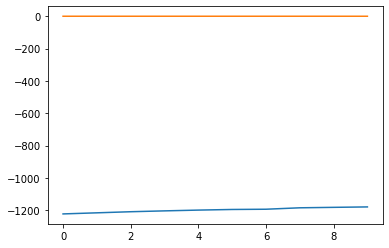

In [7]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score


losses = []
silhouette_scores = []
for cluster in range(15,25):
    kmeans = KMeans(n_clusters = cluster, random_state=1)
    kmeans.fit(embeddings)
    print(f'Inertia: {kmeans.score(embeddings)}')
    losses.append(kmeans.score(embeddings))
    print(f'Silhouette scores: {silhouette_score(embeddings, kmeans.labels_)}')
    silhouette_scores.append(silhouette_score(embeddings, kmeans.labels_))

plt.plot(losses)

In [65]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 20, random_state=1)
kmeans.fit(embeddings)

KMeans(n_clusters=20, random_state=1)

In [66]:
data['bert_kmeans_clusters'] = kmeans.labels_
data.head()

,Unnamed: 0,responce,question,langue,bert_kmeans_clusters
0,603,@115904 We'll be sure to pass along your kind words! #AATeam,erica team amazing give raise ty,1,17
1,605,@115904 Our apologies for the delay in responding to you. Have you made it to LAX? Let us know if you still need assistance.,could someone team available guide gate asap,1,18
2,608,"@115905 Aww, that's definitely a future pilot in the making! #HappyHalloween",ben tennyson american airlines pilot,1,15
3,612,@115906 We're sorry for your frustration.,right earned also pay pass spouse you need change program,1,4
4,618,@115909 We're glad you got to kick back and enjoy a show while flying! Thanks for your kind words.,thank playing great attendants back home,1,19


In [67]:
data.bert_kmeans_clusters.value_counts()

9     172
19    119
14    117
6     112
2     110
18    102
11     99
10     96
16     93
3      91
15     89
8      87
0      85
5      84
13     82
4      76
7      73
17     60
1      54
12     17
Name: bert_kmeans_clusters, dtype: int64

Topics looks much more balanced with Kmeans. The topic we get are interesting but let's try to find a better approach.

### Using Word2Vec to group sentences by similarity


This time we will leverage the power of Word2vec to get a high dimensional representation of words. It's an older technique than transformers but it often provides good results. 

In [5]:
from gensim.utils import simple_preprocess

# more traditional deep learning algorithms require some extra preprocessing (vs Transformers)
data['question']=data['question'].apply(lambda x: simple_preprocess(x))

Here we can choose to specialize the model on our dataset or use a pretrain version of it.

In [7]:
from gensim.models import Word2Vec


# build vocabulary and train model on a specific corpus
# this looks like transfer learning, we specialize on the corpus of interest
# model = Word2Vec(sentences=data['question'].tolist(), window=10,
#                     vector_size=300, min_count=2, workers=-1) 
# model.save('w2v.model')

# pretrained model
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300-SLIM.bin', binary=True)  


Once we have our train model, we can encode our dataset. To work on the document level, we average the embedding of each word in the document.

In [6]:
import gensim
import numpy as np


# def vectorize(tokenized_sentence):
#     result = []
#     for token in tokenized_sentence:
#         if token in model.wv: 
#             result.append(model.wv[token]) # get numpy vector of a word
#     result = np.asarray(result)
            
#     return result.mean(axis=0) # average of word vectors in sentence


def vectorize(tokenized_sentence):
    result = []
    for token in tokenized_sentence:
        if token in model: 
            result.append(model[token]) # get numpy vector of a word
    result = np.asarray(result)
            
    return result.mean(axis=0) # average of word vectors in sentence


data['vectorized_question'] = data['question'].apply(vectorize)


/tmp/ipykernel_44686/3272721093.py:23: RuntimeWarning: Mean of empty slice.
  return result.mean(axis=0) # average of word vectors in sentence


We will build a clustering algorithm with those embeddings. Using similarity matrix (based on cosine similarity) and hierarchical clustering.

In [42]:
from scipy.cluster import  hierarchy
 
# hierarchical clustering based on cosine
threshold = 0.5
cos_sim_matrix = hierarchy.linkage(data['vectorized_question'].values, "average", metric="cosine")
clusters = hierarchy.fcluster(cos_sim_matrix, threshold, criterion="distance")

And with Kmeans clustering.

In [24]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 20, random_state=1)
kmeans.fit(data['vectorized_question'].values)


In [ ]:
data["word2vec_cluster"] = kmeans.labels_
data.word2vec_cluster.value_counts()

### Using Doc2Vec

Doc2Vec is an improvment in comparison of the simple averaging of word vectors, it will be more granular in extracting the whole context of the document.


In [5]:
from gensim.utils import simple_preprocess

# more traditional deep learning algorithms require some extra preprocessing (vs Transformers)
data['question']=data['question'].apply(lambda x: " ".join(simple_preprocess(x)))

In [6]:
# Tag our dataset
questions = data.question
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(questions)]

In [7]:
tagged_data[:1]

[TaggedDocument(words=['erica', 'team', 'amazing', 'give', 'raise', 'ty'], tags=['0'])]

#### Build and train Doc2vec model 

Distributed Memory model preserves the word order in a document whereas Distributed Bag of words just uses the bag of words approach, which doesn’t preserve any word order. 

Here the order seems to be important, so we use Distributed Memory model with the help of the dm=1 argument.

In [10]:
from gensim.models.doc2vec import Doc2Vec
 

model = Doc2Vec(vector_size=200, alpha=.025, min_alpha=.0005, dm=1, min_count=1, workers=14)

model.build_vocab(tagged_data)

for epoch in range(100):
    if epoch%10 == 0:
        print('iteration {0}'.format(epoch))
        
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.epochs)
    # decrease the learning rate
    model.alpha -= .0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")

iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
Model Saved


In [16]:
# to find the vector of a document which is not in training data
test_data = word_tokenize("Could you have someone on your lax team available to guide me to my gate ?".lower())
v1 = model.infer_vector(test_data)
print("Inference: ", v1[:5], "\n")

# to find most similar doc using tags
similar_doc = model.dv.most_similar([v1])
print("Most similar doc: ", similar_doc[:5], "\n")

# to find vector of doc in training data using tags or in other words, printing the vector of document at index 1 in training data
print("Training vector 1: ", model.dv['1'][:5], "\n")

Inference:  [-0.04382083 -0.0205706   0.00856228  0.0008121  -0.0028752 ] 

Most similar doc:  [('1', 0.3483034074306488), ('1442', 0.21426796913146973), ('140', 0.1648252308368683), ('1100', 0.1543259620666504), ('1079', 0.1309909224510193)] 

Training vector 1:  [-0.1427832  -0.14770156  0.54968774  0.6640227   1.3668473 ] 



The docvecs/dv property of the Doc2Vec model holds all trained vectors for the 'document tags' seen during training. 

Now we have trained embeddings and it’s time to cluster it.

In [20]:
data['embedded_question']= model.dv
data.head()

,Unnamed: 0,responce,question,langue,embedded_question
0,603,@115904 We'll be sure to pass along your kind words! #AATeam,Erica team amazing give raise ty,1,"[[-0.2704825, -0.19463374, 0.5872861, 0.1377196, 0.9620227, -0.12048506, -0.5185947, 0.6365868, 0.021077493, 0.99285805, -0.62686443, 0.007765181, -0.0787885, -0.060318545, -0.18594258, -0.27315298, -0.6616099, -0.025207745, -0.10899984, -0.5486979, 0.45712033, 0.096093886, 0.55158067, 0.3555808, 0.15915123, 0.0972394, 0.24523453, -0.46944797, -0.5500069, 0.7076424, 0.62199545, 0.31785524, 0.40168226, 0.41589835, 0.5547192, -0.17608769, 0.0649512, 0.0014388892, 0.33420357, -0.58163524, -1.10..."
1,605,@115904 Our apologies for the delay in responding to you. Have you made it to LAX? Let us know if you still need assistance.,Could someone team available guide gate ASAP,1,"[[-0.2704825, -0.19463374, 0.5872861, 0.1377196, 0.9620227, -0.12048506, -0.5185947, 0.6365868, 0.021077493, 0.99285805, -0.62686443, 0.007765181, -0.0787885, -0.060318545, -0.18594258, -0.27315298, -0.6616099, -0.025207745, -0.10899984, -0.5486979, 0.45712033, 0.096093886, 0.55158067, 0.3555808, 0.15915123, 0.0972394, 0.24523453, -0.46944797, -0.5500069, 0.7076424, 0.62199545, 0.31785524, 0.40168226, 0.41589835, 0.5547192, -0.17608769, 0.0649512, 0.0014388892, 0.33420357, -0.58163524, -1.10..."
2,608,"@115905 Aww, that's definitely a future pilot in the making! #HappyHalloween",Ben Tennyson American Airlines pilot . …,1,"[[-0.2704825, -0.19463374, 0.5872861, 0.1377196, 0.9620227, -0.12048506, -0.5185947, 0.6365868, 0.021077493, 0.99285805, -0.62686443, 0.007765181, -0.0787885, -0.060318545, -0.18594258, -0.27315298, -0.6616099, -0.025207745, -0.10899984, -0.5486979, 0.45712033, 0.096093886, 0.55158067, 0.3555808, 0.15915123, 0.0972394, 0.24523453, -0.46944797, -0.5500069, 0.7076424, 0.62199545, 0.31785524, 0.40168226, 0.41589835, 0.5547192, -0.17608769, 0.0649512, 0.0014388892, 0.33420357, -0.58163524, -1.10..."
3,612,@115906 We're sorry for your frustration.,"Right , I earned . I also ’ pay pass spouse . You need change program .",1,"[[-0.2704825, -0.19463374, 0.5872861, 0.1377196, 0.9620227, -0.12048506, -0.5185947, 0.6365868, 0.021077493, 0.99285805, -0.62686443, 0.007765181, -0.0787885, -0.060318545, -0.18594258, -0.27315298, -0.6616099, -0.025207745, -0.10899984, -0.5486979, 0.45712033, 0.096093886, 0.55158067, 0.3555808, 0.15915123, 0.0972394, 0.24523453, -0.46944797, -0.5500069, 0.7076424, 0.62199545, 0.31785524, 0.40168226, 0.41589835, 0.5547192, -0.17608769, 0.0649512, 0.0014388892, 0.33420357, -0.58163524, -1.10..."
4,618,@115909 We're glad you got to kick back and enjoy a show while flying! Thanks for your kind words.,"Thank , playing great attendants back home !",1,"[[-0.2704825, -0.19463374, 0.5872861, 0.1377196, 0.9620227, -0.12048506, -0.5185947, 0.6365868, 0.021077493, 0.99285805, -0.62686443, 0.007765181, -0.0787885, -0.060318545, -0.18594258, -0.27315298, -0.6616099, -0.025207745, -0.10899984, -0.5486979, 0.45712033, 0.096093886, 0.55158067, 0.3555808, 0.15915123, 0.0972394, 0.24523453, -0.46944797, -0.5500069, 0.7076424, 0.62199545, 0.31785524, 0.40168226, 0.41589835, 0.5547192, -0.17608769, 0.0649512, 0.0014388892, 0.33420357, -0.58163524, -1.10..."


In [21]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeans_35 = KMeans(n_clusters = 35, random_state=1)
kmeans_35.fit(model.dv.vectors)
print(f'Inertia: {kmeans_35.score(model.dv.vectors)}')
print(f'Silhouette scores: {silhouette_score(model.dv.vectors, kmeans_35.labels_)}')

Inertia: -86499.53125
Silhouette scores: -0.08391577005386353


In [22]:
data['doc2vec_kmeans_35clusters'] = kmeans_35.labels_
data['doc2vec_kmeans_35clusters'].value_counts()

5     271
31    201
10    139
30    112
15    112
12     99
4      93
26     91
16     79
33     77
25     71
2      60
3      58
9      50
13     49
8      47
14     46
0      45
24     41
20     27
11     23
22      4
7       4
1       4
27      4
34      2
32      1
17      1
29      1
28      1
19      1
23      1
18      1
6       1
21      1
Name: doc2vec_kmeans_35clusters, dtype: int64

Again, we encounter cluster imballanced. Bert is still the best option so far.

### Using Top2Vec

Top2Vec is a package that automate the whole intents extraction pipeline, it's faster. But we lose some customization options.

Steps:
- Generate embedding vectors for documents and words.
- Perform dimensionality reduction on the vectors using an algorithm such as UMAP.
- Cluster the vectors using a clustering algorithm such as HDBSCAN.
- Assign topics to each cluster.

In [109]:
data['question'].head()

0                                       Erica lax team amazing give raise ty
1                           Could someone lax team available guide gate ASAP
2                                   Ben Tennyson American Airlines pilot . …
3    Right , I earned . I also ’ pay pass spouse . You need change program .
4                               Thank , playing great attendants back home !
Name: question, dtype: object

In [93]:
from top2vec import Top2Vec

model = Top2Vec(data['question'].values, speed="deep-learn", embedding_model='universal-sentence-encoder')

2022-06-13 16:40:26,716 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2022-06-13 16:40:26,757 - top2vec - INFO - Downloading universal-sentence-encoder model
INFO:top2vec:Downloading universal-sentence-encoder model
2022-06-13 16:40:29,131 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2022-06-13 16:40:29,420 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2022-06-13 16:40:33,678 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2022-06-13 16:40:33,713 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


In [114]:
def query_topics(doc):
    topics_words, word_scores, topic_scores, topic_nums = model.query_topics(doc, 1)
    return topic_nums[0]

data['top2vec_clusters']=data['question'].apply(lambda x: query_topics(x))
data.head()


,Unnamed: 0,responce,question,langue,top2vec_clusters
0,603,@115904 We'll be sure to pass along your kind words! #AATeam,Erica lax team amazing give raise ty,1,15
1,605,@115904 Our apologies for the delay in responding to you. Have you made it to LAX? Let us know if you still need assistance.,Could someone lax team available guide gate ASAP,1,13
2,608,"@115905 Aww, that's definitely a future pilot in the making! #HappyHalloween",Ben Tennyson American Airlines pilot . …,1,9
3,612,@115906 We're sorry for your frustration.,"Right , I earned . I also ’ pay pass spouse . You need change program .",1,6
4,618,@115909 We're glad you got to kick back and enjoy a show while flying! Thanks for your kind words.,"Thank , playing great attendants back home !",1,15


In [115]:
data['top2vec_clusters'].value_counts()

2     146
1     144
3     136
0     136
5     125
4     109
6     101
7      97
8      94
12     84
9      77
15     76
10     69
13     68
11     67
16     64
17     55
14     51
19     44
18     44
20     31
Name: top2vec_clusters, dtype: int64

The clusters are balanced, it seems that we are going to explore the actual intents with LDA, Bert and Top2Vec. We eliminate Doc2vec and Word2vec so far.

## Intents Extraction 

Here we want to understand what our clusters actually mean.

An interesting approach for this is to obtain the most common action / object pair from the phrases in each cluster as the cluster label ("refund / policy", "delay / flight"). Spacy library is amazing for this task because we can extract verbs, ojects, nouns... from a sentence.

In [18]:
import collections


def most_common(lst, n_words):
    
    counter=collections.Counter(lst)
    return counter.most_common(n_words)

def extract_labels(list_docs):

    verbs = []
    dobjs = []
    nouns = []
    adjs = []
    
    verb = ''
    dobj = ''
    noun1 = ''
    noun2 = ''

    # for each document, append verbs, dobs, nouns, and adjectives to 
    # running lists for whole cluster
    for i in range(len(list_docs)):
        doc = nlp(list_docs[i])
        for token in doc:
            if token.is_stop==False:
                if token.dep_ == 'ROOT':
                    verbs.append(token.text.lower())
                elif token.dep_=='dobj':
                    dobjs.append(token.lemma_.lower())
                elif token.pos_=='NOUN':
                    nouns.append(token.lemma_.lower())     
                elif token.pos_=='ADJ':
                    adjs.append(token.lemma_.lower())
    
    # take most common words of each kind
    if len(verbs) > 0:
        verb = most_common(verbs, 1)[0][0]
    if len(dobjs) > 0:
        dobj = most_common(dobjs, 1)[0][0]
    if len(nouns) > 0:
        noun1 = most_common(nouns, 1)[0][0]
    if len(set(nouns)) > 1:
        noun2 = most_common(nouns, 2)[1][0]
    
    # concatenate the most common words of each kind
    label_words = [verb, dobj]
    
    for word in [noun1, noun2]:
        if word not in label_words:
            label_words.append(word)

    if '' in label_words:
        label_words.remove('')
    
    label = '_'.join(label_words)
    
    return label

For TOP2VEC :

In [127]:
intents = {}
for cluster in data['top2vec_clusters'].unique().tolist():
    intents['cluster_' + str(cluster)] = extract_labels(data[data['top2vec_clusters']==cluster]['question'].tolist())

In [128]:
intents

{'cluster_15': 'thank_job_today',
 'cluster_13': 'gate_gate_agent',
 'cluster_9': '@_miami_thank_today',
 'cluster_6': 'booked_ticket_mile',
 'cluster_3': 'rude_service_attendant',
 'cluster_19': 'help_app_problem',
 'cluster_7': 'thank_response_guy',
 'cluster_11': 'dfw_pilot_hour_tomorrow',
 'cluster_20': 'able',
 'cluster_17': 'upgrade_upgrade_thank',
 'cluster_12': 'need_mind_time_today',
 'cluster_1': 'check_bag_baggage',
 'cluster_16': 'got_meal_amp_food',
 'cluster_5': 'want_seat_row',
 'cluster_2': 'delayed_delay_hour',
 'cluster_8': 'thank_family_holiday_day',
 'cluster_10': 'sitting_tarmac_hour_gate',
 'cluster_0': 'cancelled_customer_day_pilot',
 'cluster_4': 'service_service_customer',
 'cluster_14': 'aa_aa_year',
 'cluster_18': 'dm_dm_record'}

For BERT/KMEANS:

In [68]:
# data['question'] = data['question'].apply(lambda x: " ".join(x))

intents = {}
for cluster in data['bert_kmeans_clusters'].unique().tolist():
    intents['cluster_' + str(cluster)] = extract_labels(data[data['bert_kmeans_clusters']==cluster]['question'].tolist())

In [69]:
intents

{'cluster_17': 'tell_friend_medium_thank',
 'cluster_18': 'send_response_ticket_aa',
 'cluster_15': 'flown_pilot_time',
 'cluster_4': 'pay_ticket_mile',
 'cluster_19': 'thank_attendant_flight_service',
 'cluster_5': 'delayed_hour_delay',
 'cluster_8': 'called_ticket_day_customer',
 'cluster_2': 'paid_seat_class',
 'cluster_7': 'thank_thank_dm',
 'cluster_16': 'tried_response_upgrade_app',
 'cluster_6': 'thank_thank_today',
 'cluster_9': 'going_family_time_year',
 'cluster_1': 'carry_bag_gate',
 'cluster_3': 'closed_home_aa_amp',
 'cluster_10': 'cancelled_refund_customer_cancellation',
 'cluster_11': 'delayed_gate_hour',
 'cluster_13': 'bags_bag_luggage',
 'cluster_0': 'understand_service_customer',
 'cluster_14': 'dfw_screen_thank_day',
 'cluster_12': ''}

#### For LDA 

In [20]:
data.head()

,Unnamed: 0,responce,question,langue,bigrams,lemma,lda_topic
0,603,@115904 We'll be sure to pass along your kind words! #AATeam,"[erica, team, amazing, give, raise, ty]",1,"[erica, team, amazing, give, raise, ty]","[amaze, give, raise]",14
1,605,@115904 Our apologies for the delay in responding to you. Have you made it to LAX? Let us know if you still need assistance.,"[could, someone, team, available, guide, gate, asap]",1,"[could, someone, team, available, guide, gate, asap]","[team, available, gate, asap]",3
2,608,"@115905 Aww, that's definitely a future pilot in the making! #HappyHalloween","[ben, tennyson, american, airlines, pilot]",1,"[ben, tennyson, american_airlines, pilot]",[],18
3,612,@115906 We're sorry for your frustration.,"[right, earned, also, pay, pass, spouse, you, need, change, program]",1,"[right, earned, also, pay, pass, spouse, you, need, change, program]","[right, earn, also, pay, pass, spouse, need, change, program]",7
4,618,@115909 We're glad you got to kick back and enjoy a show while flying! Thanks for your kind words.,"[thank, playing, great, attendants, back, home]",1,"[thank, playing, great, attendants, back, home]","[thank, play, great, attendant, back, home]",12


In [24]:
data['question'] = data['question'].apply(lambda x: " ".join(x))
data['question'].head()

0                             erica team amazing give raise ty
1                 could someone team available guide gate asap
2                         ben tennyson american airlines pilot
3    right earned also pay pass spouse you need change program
4                     thank playing great attendants back home
Name: question, dtype: object

In [25]:
intents = {}
for cluster in data['lda_topic'].unique().tolist():
    intents['cluster_' + str(cluster)] = extract_labels(data[data['lda_topic']==cluster]['question'].tolist())

In [26]:
intents

{'cluster_14': 'cancelled_status_dm_record',
 'cluster_3': 'know_passenger_pilot_gate',
 'cluster_18': 'help_service_customer',
 'cluster_7': 'thank_trip_way',
 'cluster_12': 'delayed_issue_hour_delay',
 'cluster_4': 'thank_ticket_bag',
 'cluster_20': 'upgraded_class_club',
 'cluster_2': 'going_pm_airport_minute',
 'cluster_9': 'able_leg_child_mom',
 'cluster_11': 'happened_people_flight_idea',
 'cluster_1': 'got_time_home_hour',
 'cluster_13': 'waiting_year_minute_medium',
 'cluster_15': 'cause_problem_amp',
 'cluster_8': 'flown_connection_time_month',
 'cluster_10': 'said_time_pilot_minute',
 'cluster_21': 'need_bag_baggage',
 'cluster_5': 'thank_thank_year',
 'cluster_6': 'think_point_people_dog',
 'cluster_16': 'want_customer_people_flagship',
 'cluster_0': 'bring_seat_today',
 'cluster_17': 'dfw_agent_gate',
 'cluster_19': 'sent_website_week_day'}

It seems that the BERT + KMEANS combinaison gave us the best results. We will now further optimize this model and build the chatbot.